In [7]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [8]:
# ls 'gdrive/My Drive/01_hackathon/aiat-hackathon-1-2020.zip'
# !ls 'gdrive/My Drive/01_hackathon/model'

In [9]:
# !unzip '/content/gdrive/My Drive/lab3-nvidia-chula.zip'
# !unzip 'gdrive/My Drive/01_hackathon/aiat-hackathon-1-2020.zip'

In [10]:
# Downgrade Pillow to avoid errors
!pip install Pillow==3.4.2

import tensorflow as tf
# import tensorflow.compat.v1 as tf
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.applications.inception_resnet_v2 import InceptionResNetV2

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Model
from keras import optimizers 
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from time import time

from numpy.random import seed
seed(12)
# from tensorflow import set_random_seed
# set_random_seed(12)
tf.random.set_seed(12)

import matplotlib.pyplot as plt
import numpy as np
np.random.seed(12)

from sklearn.metrics import classification_report, f1_score, accuracy_score
import glob
from tqdm import tqdm
import warnings

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Variable path Setting
- training, validation, testing and model path directories.

In [11]:
# !ls 'gdrive/My Drive/01_hackathon/train'

In [18]:
train_dir = "./gdrive/My Drive/01_hackathon/train"
val_dir = "./gdrive/My Drive/01_hackathon/val"
test_dir = "./gdrive/My Drive/01_hackathon/test_release"

## Data preprocessing

Read training and validation dataset
- Data augmentation strategies using ImageDataGenerator

In [13]:
image_size = 224
num_class = 3
batch_size=8 # try reducing batch size or freeze more layers if your GPU runs out of memory
train_datagen = ImageDataGenerator()

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=(224,224),
        batch_size=batch_size,
        class_mode='categorical')

Found 3357 images belonging to 3 classes.
Found 2108 images belonging to 3 classes.


In [14]:
x, y = train_generator.next()

Define f1_score metric for evaluating model 

In [15]:
def f1_score_metric(y_true, y_pred):
    y_true = tf.cast(y_true, "int32")
    y_pred = tf.cast(tf.round(y_pred), "int32") # implicit 0.5 threshold via tf.round
    y_correct = y_true * y_pred
    sum_true = tf.reduce_sum(y_true, axis=1)
    sum_pred = tf.reduce_sum(y_pred, axis=1)
    sum_correct = tf.reduce_sum(y_correct, axis=1)
    precision = sum_correct / sum_pred
    recall = sum_correct / sum_true
    f_score = 5 * precision * recall / (4 * precision + recall)
    # f_score = tf.where(tf.is_nan(f_score), tf.zeros_like(f_score), f_score)
    f_score = tf.where(tf.math.is_nan(f_score), tf.zeros_like(f_score), f_score)
    return tf.reduce_mean(f_score)

## Model 1
- VGG19 (random initialized weights) + 2 Dense layers + Output layer

In [3]:
base_model = VGG19(weights=None, include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = True
x = base_model.output
x = Flatten()(x)
x = Dense(1024)(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = Dropout(0.5)(x)
output = Dense(num_class, activation='softmax')(x)
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.1, patience=10,
                                verbose=1, min_delta=0.0001, cooldown=5, min_lr=0)
early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=0, mode='max')
# model_1_path = "./model/lab3_1/{}.h5".format("model_1")
model_1_path = "gdrive/My Drive/01_hackathon/model/{}.h5".format("model_1")
checkpoint = ModelCheckpoint(model_1_path, monitor='val_accuracy', verbose=1,save_best_only=True,save_weights_only=False, mode='max',period=1)
callbacks_list = [checkpoint,early_stopper,reduce_lr]
# Create and compile model
model_1 = Model(inputs=base_model.input, outputs=output)
model_1.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=0.0001),metrics=["accuracy", f1_score_metric])

# Load last epoch model
# pretrined_model_1_path = "./model/const_models/lab3_1/model_1.h5"
# model_1.load_weights(pretrined_model_1_path)

## Run until early stopping
num_training_img=3357
num_validation_img=2108
stepsPerEpoch = num_training_img//batch_size
validationSteps= num_validation_img//batch_size
model_1.fit_generator(
        train_generator,
        steps_per_epoch=stepsPerEpoch,
        epochs=50,
        callbacks = callbacks_list,
        validation_data = validation_generator,
        validation_steps=validationSteps
        )

NameError: ignored

## Model 2
- VGG (pre-trained weights) + 2 Dense layers + Output layer
- Freezes all weights of base model layers

In [16]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(1024)(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = Dropout(0.5)(x)
output = Dense(num_class, activation='softmax')(x)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.1, patience=10,
                                verbose=1, min_delta=0.0001, cooldown=5, min_lr=0)

early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=20, verbose=0, mode='max')

# model_2_path = "./model/lab3_1/{}.h5".format("model_2")
model_2_path = "gdrive/My Drive/01_hackathon/model/{}.h5".format("model_2")
checkpoint = ModelCheckpoint(model_2_path, monitor='val_accuracy', verbose=1,save_best_only=True,save_weights_only=False, mode='max',period=1)
callbacks_list = [checkpoint,early_stopper,reduce_lr]

# Create and compile model
model_2 = Model(inputs=base_model.input, outputs=output)
model_2.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=0.0001),metrics=["accuracy", f1_score_metric])

# Load last epoch model
# pretrined_model_2_path = "gdrive/My Drive/01_hackathon/model/model_2.h5"
# model_2.load_weights(pretrined_model_2_path)

# Run until early stopping
# num_training_img=784
# num_validation_img=85
# stepsPerEpoch = num_training_img/batch_size
# validationSteps= num_validation_img/batch_size
# model_2.fit_generator(
#         train_generator,
#         steps_per_epoch=stepsPerEpoch,
#         epochs=50,
#         callbacks = callbacks_list,
#         validation_data = validation_generator,
#         validation_steps=validationSteps
#         )

## Model 3
- VGG19 (pre-trained weights) + 2 Dense layers + Output layer
- use basic Fine-tuning technique which unfreezes all layers.

In [ ]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(num_class, activation='softmax')(x)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.1, patience=10,
                                verbose=1, min_delta=0.0001, cooldown=5, min_lr=0)

early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=0, mode='max')

# model_3_path = "./model/lab3_1/{}.h5".format("model_3")
model_3_path = "gdrive/My Drive/01_hackathon/model/{}.h5".format("model_3")
checkpoint = ModelCheckpoint(model_3_path, monitor='val_accuracy', verbose=1,save_best_only=True,save_weights_only=False, mode='max',period=1)
callbacks_list = [checkpoint,early_stopper,reduce_lr]

# Create and compile model
model_3 = Model(inputs=base_model.input, outputs=output)
model_3.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=0.00001),metrics=["accuracy", f1_score_metric])

# Load last epoch model
# pretrined_model_3_path = "gdrive/My Drive/01_hackathon/model/model_3.h5"
# model_3.load_weights(pretrined_model_3_path)

# Run until early stopping
num_training_img=784
num_validation_img=85
stepsPerEpoch = num_training_img/batch_size
validationSteps= num_validation_img/batch_size
history = model_3.fit_generator(
                    train_generator,
                    steps_per_epoch=stepsPerEpoch,
                    epochs=50,
                    callbacks = callbacks_list,
                    validation_data = validation_generator,
                    validation_steps=validationSteps
                    )

In [17]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'val_f1_score_metric', 'loss', 'accuracy', 'f1_score_metric', 'lr'])

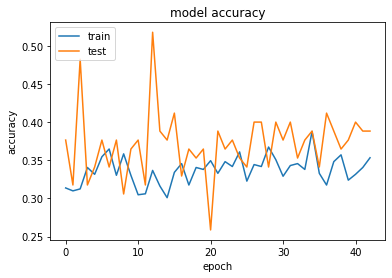

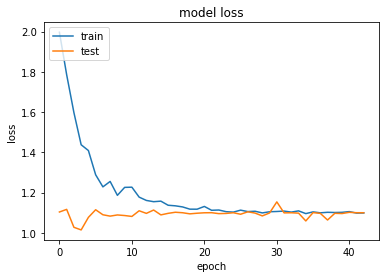

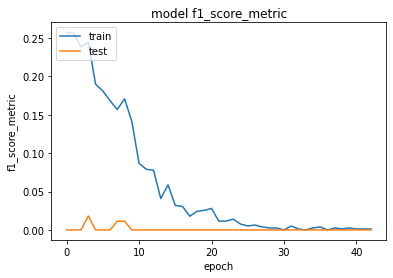

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for f1_score
plt.plot(history.history['f1_score_metric'])
plt.plot(history.history['val_f1_score_metric'])
plt.title('model f1_score_metric')
plt.ylabel('f1_score_metric')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model 4
- VGG (pre-trained weights) + 2 Dense layers + Output layer
- use `Chain-thaw` Fine-tuning technique, referenced by [Using millions of emoji occurrences to learn any-domain representations for detecting sentiment, emotion and sarcasm](https://arxiv.org/pdf/1708.00524.pdf).

In [29]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(448, 448, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = Flatten()(x)
x = Dense(1024)(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = Dropout(0.5)(x)
output = Dense(num_class, activation='softmax')(x)
# Create  model
model_4 = Model(inputs=base_model.input, outputs=output)


# num_training_img=3357
# num_validation_img=2108
# stepsPerEpoch = num_training_img/batch_size
# validationSteps= num_validation_img/batch_size
# base_model_layers = model_4.layers[:23]
# new_model_layers =  model_4.layers[23:]
# base_model_blocks = {
#     0: base_model_layers[1:3],
#     1: base_model_layers[4:6],
#     2: base_model_layers[7:11],
#     3: base_model_layers[12:16],
#     4: base_model_layers[17:21]
# }

In [17]:
print("\n--[Phase 1]--: Train only new layers")

for layer in base_model_layers:
    layer.trainable = False

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.1, patience=10,
                                verbose=1, min_delta=0.0001, cooldown=5, min_lr=0)

early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=25, verbose=0, mode='max')

# model_4_path = os.path.abspath(os.path.join(curr_dir, "./model/const_models/lab3_1/{}.h5".format("model_4_1")))
model_4_path = "gdrive/My Drive/01_hackathon/model/{}.h5".format("model_4_1")

checkpoint = ModelCheckpoint(model_4_path, monitor='val_accuracy', verbose=1,save_best_only=True,save_weights_only=False, mode='max',period=1)
callbacks_list = [checkpoint,early_stopper,reduce_lr]
    
model_4.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=0.0001), metrics=["accuracy", f1_score_metric])

model_4.fit_generator(
    train_generator,
    steps_per_epoch=stepsPerEpoch,
    epochs=50,
    callbacks=callbacks_list,
    validation_data=validation_generator,
    validation_steps=validationSteps
    )


--[Phase 1]--: Train only new layers
Epoch 1/50
420/419 [==============================] - 1688s 4s/step - loss: 40.2181 - accuracy: 0.6032 - f1_score_metric: 0.6034 - val_loss: 12.2936 - val_accuracy: 0.7263 - val_f1_score_metric: 0.7263

Epoch 00001: val_accuracy improved from -inf to 0.72628, saving model to gdrive/My Drive/01_hackathon/model/model_4_1.h5
Epoch 2/50
420/419 [==============================] - 67s 160ms/step - loss: 26.5029 - accuracy: 0.7563 - f1_score_metric: 0.7565 - val_loss: 0.0110 - val_accuracy: 0.8235 - val_f1_score_metric: 0.8239

Epoch 00002: val_accuracy improved from 0.72628 to 0.82353, saving model to gdrive/My Drive/01_hackathon/model/model_4_1.h5
Epoch 3/50
420/419 [==============================] - 65s 155ms/step - loss: 18.4000 - accuracy: 0.8359 - f1_score_metric: 0.8358 - val_loss: 0.0000e+00 - val_accuracy: 0.8866 - val_f1_score_metric: 0.8868

Epoch 00003: val_accuracy improved from 0.82353 to 0.88662, saving model to gdrive/My Drive/01_hackathon

In [18]:
print("\n--[Phase 2]--: Train every CNN blocks of base model (5 blocks)")

# model_4_prev_path = os.path.abspath(os.path.join(curr_dir, "./model/const_models/lab3_1/model_4_1.h5"))
model_4_prev_path = "gdrive/My Drive/01_hackathon/model/model_4_1.h5"

print("Loading the previous weight from {}.".format(model_4_prev_path))
model_4.load_weights(model_4_prev_path)

for layer in new_model_layers:
    layer.trainable = False

for idx in range(0, 5):
  
    # train idx block
    print("[Train block{}]: containing {} layers".format(idx, len(base_model_blocks[idx])))
    
    # Callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.1, patience=4,
                                    verbose=1, min_delta=0.0001, cooldown=2, min_lr=0)
    early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                               patience=10, verbose=0, mode='max')

    # model_4_path = os.path.abspath(os.path.join(curr_dir, f"./model/const_models/lab3_1/model_4_2_{idx}.h5"))
    # model_4_path = "gdrive/My Drive/01_hackathon/model/{}.h5".format("model_4_1")
    model_4_path = f"./gdrive/My Drive/01_hackathon/model/model_4_2_{idx}.h5"
    
    checkpoint = ModelCheckpoint(model_4_path, monitor='val_accuracy', verbose=1,save_best_only=True,save_weights_only=False, mode='max',period=1)
    callbacks_list = [checkpoint,early_stopper,reduce_lr]

    for layer in base_model_layers:
        if layer in base_model_blocks[idx]:
            layer.trainable = True
            print("train {}".format(layer))
        else:
            layer.trainable = False
    model_4.compile(loss="categorical_crossentropy",
                  optimizer=optimizers.Adam(lr=0.000001), metrics=["accuracy", f1_score_metric])
    model_4.fit_generator(
        train_generator,
        steps_per_epoch=stepsPerEpoch,
        epochs=50,
        callbacks=callbacks_list,
        validation_data=validation_generator,
        validation_steps=validationSteps
    )


--[Phase 2]--: Train every CNN blocks of base model (5 blocks)
Loading the previous weight from gdrive/My Drive/01_hackathon/model/model_4_1.h5.
[Train block0]: containing 2 layers
train <keras.layers.convolutional.Conv2D object at 0x7fbd9a889b38>
train <keras.layers.convolutional.Conv2D object at 0x7fbde5658780>
Epoch 1/50
420/419 [==============================] - 69s 165ms/step - loss: 0.3835 - accuracy: 0.9943 - f1_score_metric: 0.9943 - val_loss: 0.0000e+00 - val_accuracy: 0.8937 - val_f1_score_metric: 0.8939

Epoch 00001: val_accuracy improved from -inf to 0.89374, saving model to ./gdrive/My Drive/01_hackathon/model/model_4_2_0.h5
Epoch 2/50
420/419 [==============================] - 69s 164ms/step - loss: 0.4504 - accuracy: 0.9943 - f1_score_metric: 0.9943 - val_loss: 158.5484 - val_accuracy: 0.8899 - val_f1_score_metric: 0.8897

Epoch 00002: val_accuracy did not improve from 0.89374
Epoch 3/50
420/419 [==============================] - 68s 162ms/step - loss: 0.5463 - accuracy

## `To do` 

You are supposed to implement `Chain-thaw` Fine-tuning technique in the last phase which is to unfreeze all of model layers and train it to be well adapted to the target task.

HINT: you should load the last epoch model weights from provided const-model folder before training model with `fit_generator` function from the code below.


```python
pretrined_model_4_path = "./model/const_models/lab3_1/model_4_3.h5"
model_4.load_weights(pretrined_model_4_path)
```


Noted that there are still needs for both `ModelCheckpoint` callback, saving model to the path, and `EarlyStopping` is still required.

The solution can be seen in the cell below.

In [19]:
print("--[Phase 3]--: Train all layers")

for layer in model_4.layers:
    layer.trainable = True

# Callbacks

reduce_lr = ReduceLROnPlateau(monitor='val_f1_score_metric', mode='max', factor=0.1, patience=10,
                                verbose=1, min_delta=0.0001, cooldown=5, min_lr=0)

early_stopper = EarlyStopping(monitor='val_f1_score_metric', min_delta=0, 
                           patience=30, verbose=0, mode='max')

# model_4_path = "./model/lab3_1/{}.h5".format("model_4")
model_4_path = "gdrive/My Drive/01_hackathon/model/{}.h5".format("model_4")

checkpoint = ModelCheckpoint(model_4_path, monitor='val_f1_score_metric', verbose=1,save_best_only=True,save_weights_only=False, mode='max',period=1)
callbacks_list = [checkpoint, early_stopper, reduce_lr]


model_4.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=0.00001), metrics=["accuracy", f1_score_metric])


# Load last epoch model

# pretrined_model_4_path = "gdrive/My Drive/01_hackathon/model/model_4.h5"
# model_4.load_weights(pretrined_model_4_path)


model_4.fit_generator(
    train_generator,
    steps_per_epoch=stepsPerEpoch,
    epochs=50,
    callbacks=callbacks_list,
    validation_data=validation_generator,
    validation_steps=validationSteps
)

--[Phase 3]--: Train all layers
Epoch 1/50
420/419 [==============================] - 72s 172ms/step - loss: 7.1423 - accuracy: 0.8811 - f1_score_metric: 0.8811 - val_loss: 40.9984 - val_accuracy: 0.7642 - val_f1_score_metric: 0.7633

Epoch 00001: val_f1_score_metric improved from -inf to 0.76326, saving model to gdrive/My Drive/01_hackathon/model/model_4.h5
Epoch 2/50
420/419 [==============================] - 73s 173ms/step - loss: 1.5940 - accuracy: 0.9214 - f1_score_metric: 0.9212 - val_loss: 0.0000e+00 - val_accuracy: 0.8027 - val_f1_score_metric: 0.8030

Epoch 00002: val_f1_score_metric improved from 0.76326 to 0.80303, saving model to gdrive/My Drive/01_hackathon/model/model_4.h5
Epoch 3/50
420/419 [==============================] - 73s 174ms/step - loss: 0.6170 - accuracy: 0.9586 - f1_score_metric: 0.9586 - val_loss: 2.8375 - val_accuracy: 0.8259 - val_f1_score_metric: 0.8258

Epoch 00003: val_f1_score_metric improved from 0.80303 to 0.82576, saving model to gdrive/My Drive/01_

<details>
    <summary>SOLUTION HERE!</summary>
    <pre>
        <code>

for layer in model_4.layers:
    layer.trainable = True

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_f1_score_metric', mode='max', factor=0.1, patience=10,
                                verbose=1, min_delta=0.0001, cooldown=5, min_lr=0)
early_stopper = EarlyStopping(monitor='val_f1_score_metric', min_delta=0, 
                           patience=30, verbose=0, mode='max')
model_4_path = "./model/lab3_1/{}.h5".format("model_4")
checkpoint = ModelCheckpoint(model_4_path, monitor='val_f1_score_metric', verbose=1,save_best_only=True,save_weights_only=False, mode='max',period=1)
callbacks_list = [checkpoint, early_stopper, reduce_lr]

model_4.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=0.00001), metrics=["accuracy", f1_score_metric])

# Load last epoch model
pretrined_model_4_path = "./model/const_models/lab3_1/model_4_3.h5"
model_4.load_weights(pretrined_model_4_path)

model_4.fit_generator(
    train_generator,
    steps_per_epoch=stepsPerEpoch,
    epochs=5,
    callbacks=callbacks_list,
    validation_data=validation_generator,
    validation_steps=validationSteps
)
        </code>
    </pre>
</details>

## Evaluation
-  `F-score` is really useful if you want to compare 2 classifiers. It is computed using the harmonic mean of precision and recall, and gives much more weight to low values. As a result of that, the classifier will only get a high F-score, if both recall and precision are high. You can easily compute the F-Score with sklearn.
- `Micro F1-score` is to calculate metrics globally by counting the total true positives, false negatives and false positives, while 
- `Macro F1-score` is to calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

In [20]:
class_to_idx = train_generator.class_indices
idx_to_class = {v: k for k, v in class_to_idx.items()}

In [21]:
idx_to_class

{0: 'covid', 1: 'normal', 2: 'pneumonia'}

In [30]:
# # Load the best model
# model_1_path = "./gdrive/My Drive/01_hackathon/model/{}.h5".format("model_1")
# model_2_path = "./gdrive/My Drive/01_hackathon/model/R1/{}.h5".format("model_2_30epcoh")
# model_3_path = "./gdrive/My Drive/01_hackathon/model/{}.h5".format("model_3")
model_4_path = "./gdrive/My Drive/01_hackathon/model/R2/{}.h5".format("model_4")

# model_1.load_weights(model_1_path)
# model_2.load_weights(model_2_path)
# model_3.load_weights(model_3_path)
model_4.load_weights(model_4_path)

In [31]:
# Prepare in case of problem
# model.load(model_path)

idx_to_model = {
    # 1: model_1,
    # 2: model_2
    # 3: model_3,
    4: model_4
}
idx_to_preds = {
    # 1: ([], []), # y_trues, y_preds
    # 2: ([], [])
    # 3: ([], []),
    4: ([], [])
}

for class_idx in tqdm(range(num_class)):
    label = idx_to_class[class_idx]
    file_list = glob.glob("{}/{}/*.*".format(val_dir, label))
    for raw_image in file_list:
        inputShape = (448,448) # Assumes 3 channel image
        image = load_img(raw_image, target_size=inputShape)
        image = img_to_array(image)   # shape is (224,224,3)
        image = preprocess_input(image)
        image = np.expand_dims(image, axis=0)  # Now shape is (1,224,224,3)

        model = idx_to_model[4]
        preds = model.predict(image)
        pred_class = np.argmax(preds)

        # append y_trues
        idx_to_preds[4][0].append(class_idx)
        # append y_preds
        idx_to_preds[4][1].append(pred_class)

100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


In [34]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print("Performace of each models:")
      
    y_trues = idx_to_preds[4][0]
    y_preds = idx_to_preds[4][1]
    print("-- Model_{} (acc:{:.4f}, f1_micro:{:.4f}, f1_macro:{:.4f})".format(idx,
                                                                            accuracy_score(y_trues, y_preds), 
                                                                            f1_score(y_trues, y_preds, average='micro'),
                                                                            f1_score(y_trues, y_preds, average='macro')))

Performace of each models:


NameError: ignored

In [35]:
from sklearn.metrics import f1_score 
f1_score(y_trues, y_preds, average='macro')

0.6940705411293647

In [36]:
import pandas as pd 
idx_to_model = {4: model_4}
idx_to_preds = {4: ([], [])}

file_list = glob.glob("{}/*.*".format(test_dir))

for raw_image in file_list:
  # print(raw_image)
  B = os.path.basename(raw_image)
  A = os.path.splitext(B)[0]
  print(A)
  
  inputShape = (448,448)
  image = load_img(raw_image, target_size=inputShape)
  image = img_to_array(image) 
  image = preprocess_input(image)
  image = np.expand_dims(image, axis=0)  

  model = idx_to_model[4]
  preds = model.predict(image)
  pred_class = np.argmax(preds)

  idx_to_preds[4][0].append(A)
  idx_to_preds[4][1].append(pred_class)


filenames = pd.DataFrame(idx_to_preds[4][0])
predclasss = pd.DataFrame(idx_to_preds[4][1])

com = pd.concat([filenames, predclasss], axis=1, join='inner')
com.columns = ['Id','Predicted']
com.sort_values(by=['Id'],inplace=True)
com.reset_index(drop=True, inplace=True)
com

from google.colab import files
com.to_csv('submissions5.csv')
files.download('submissions5.csv')

test015
test076
test084
test008
test014
test066
test001
test041
test009
test026
test079
test081
test055
test003
test019
test037
test007
test004
test031
test046
test036
test011
test020
test025
test085
test024
test018
test070
test032
test075
test034
test016
test038
test051
test068
test010
test060
test040
test017
test027
test005
test021
test013
test080
test063
test023
test071
test064
test058
test006
test029
test042
test028
test056
test045
test074
test022
test050
test057
test054
test048
test069
test061
test072
test073
test035
test052
test033
test012
test059
test002
test077
test053
test065
test039
test067
test062
test078
test043
test030
test049
test044
test082
test083
test047


In [34]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print("Performace of each models:")
    for idx in range(1, 5):
      
        y_trues = idx_to_preds[idx][0]
        y_preds = idx_to_preds[idx][1]
        print("-- Model_{} (acc:{:.4f}, f1_micro:{:.4f}, f1_macro:{:.4f})".format(idx,
                                                                                accuracy_score(y_trues, y_preds), 
                                                                                f1_score(y_trues, y_preds, average='micro'),
                                                                                f1_score(y_trues, y_preds, average='macro')))

Performace of each models:
-- Model_1 (acc:0.3176, f1_micro:0.3176, f1_macro:0.2034)
-- Model_2 (acc:0.3176, f1_micro:0.3176, f1_macro:0.2034)
-- Model_3 (acc:0.3882, f1_micro:0.3882, f1_macro:0.3367)
-- Model_4 (acc:0.3059, f1_micro:0.3059, f1_macro:0.2302)


## Result
to see how the model perform by testing sample visualized by matplotlib.

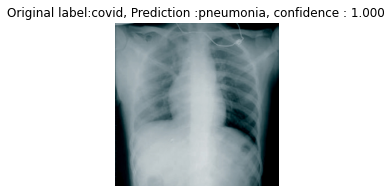

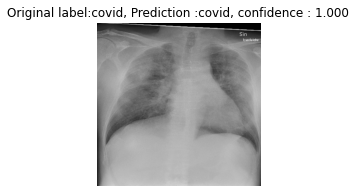

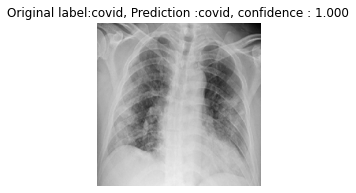

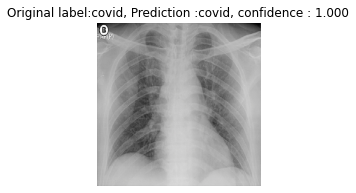

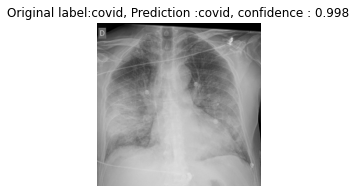

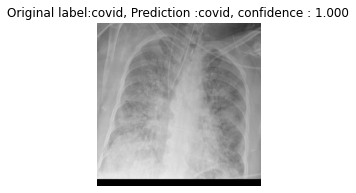

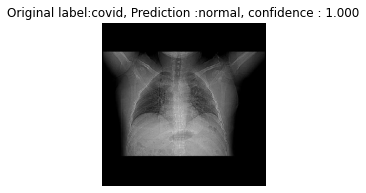

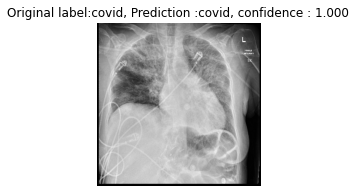

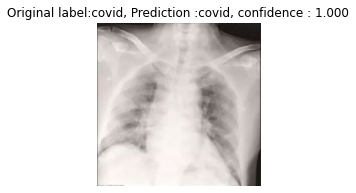

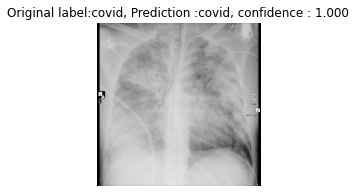

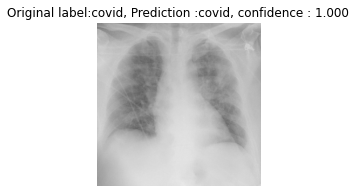

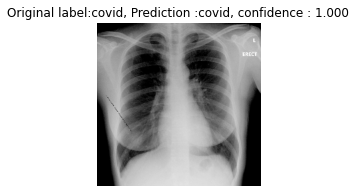

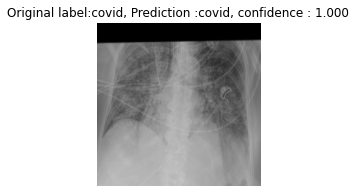

In [55]:
import random

for class_idx in random.sample(range(0, num_class), 3):
    label = idx_to_class[class_idx]
    file_list = glob.glob("{}/{}/*.*".format(val_dir, label))
    for raw_image in file_list[:]:
        inputShape = (448,448)
        image = load_img(raw_image, target_size=inputShape)
        image = img_to_array(image)
        image = preprocess_input(image)
        image = np.expand_dims(image, axis=0)

        preds = model_4.predict(image)

        pred_class = np.argmax(preds)
        pred_label = idx_to_class[pred_class]

        title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
            label,
            pred_label,
            preds[0][pred_class])

        original = load_img(raw_image, target_size=(448, 448))
        plt.figure(figsize=[3,3])
        plt.axis('off')
        plt.title(title)
        plt.imshow(original)
        plt.show()

In [ ]:
import random

for class_idx in random.sample(range(0, num_class), 3):
    label = idx_to_class[class_idx]
    file_list = glob.glob("{}/{}/*.jpg".format(val_dir, label))
    for raw_image in file_list[:]:
        inputShape = (448,448)
        image = load_img(raw_image, target_size=inputShape)
        image = img_to_array(image)
        image = preprocess_input(image)
        image = np.expand_dims(image, axis=0)

        preds = model_4.predict(image)

        pred_class = np.argmax(preds)
        pred_label = idx_to_class[pred_class]

        title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
            label,
            pred_label,
            preds[0][pred_class])

        original = load_img(raw_image, target_size=(448, 448))
        plt.figure(figsize=[3,3])
        plt.axis('off')
        plt.title(title)
        plt.imshow(original)
        plt.show()